# Sparse Gaussian Process by Varitional Inference
+ $p(u,f|y,X)$ are approximated by $q(u,f|y,X)$, where
$$ q(u,f|y,X) = \argmin_{\tilde{q}} \int \tilde{q}(u,f|y,X) \log \frac{\tilde{q}(u,f|y,X)}{p(y|f,X) p(u|f,X) p(u)} df du , \equiv \argmin_{\tilde{q}} \mathcal{F}(\tilde{q}) $$
$$ \tilde{q}(u,f|y,X) = \tilde{q}(u) \tilde{q}(f|u) = \tilde{q}(u) \prod_{i=1}^n \tilde{q}(f_i|u)$$
+ When we minimize $q(f|u)$, then it is a same form with $p(f|u)$. Thus, let $q(u) = N(u|\hat{u}, \hat{\Sigma}_u)$, then eventually,
\begin{equation} \mathcal{F} = \int \tilde{q}(u,f|y,X) \log \frac{1}{p(y|f,X)} df du + KL(q(u) || p(u)) \\
 = \sum_{i=1}^n \Bigl\{ \frac{1}{2\sigma^2} (y_i - a_i^T \hat{u})^2 + \frac{1}{2\sigma^2}\hat{\sigma}_i^2 + \frac{1}{2\sigma^2} a_i^T \hat{\Sigma}_u a_i \Bigr\} + \frac{1}{2} \log \frac{|K_{M,M}|}{|\hat{\Sigma}_u|} -\frac{M}{2} + \frac{1}{2} tr(K_{M,M}^{-1} \hat{\Sigma}_u) + \frac{1}{2} \hat{u}^T \hat{\Sigma}_u \hat{u}, \end{equation}
 where $a_i = K_{M,M}^{-1}K_{M,i}, \hat{\sigma}_i = K_{i,i} - K_{i,M} K_{M,M}^{-1} K_{M,i}$
+ Hence, to obtain the optimal $q(\cdot)$, we need to search an optimal $\hat{u}$ and $\hat{\Sigma}_u$ for $\mathcal{F}$:
    + By using gradient for both $\hat{u}$ and $\hat{\Sigma}_u$, we can obtain a local minimum. The gradients are
    \begin{equation} \frac{\partial}{\partial \hat{u}} \mathcal{F} = (K_{M,M}^{-1} + \frac{1}{\sigma^2} a^T a)\hat{u} - \frac{1}{\sigma^2}ay, \end{equation}
    \begin{equation} \frac{\partial}{\partial \hat{\Sigma}_u} \mathcal{F} = -\frac{1}{2}\hat{\Sigma}_u + \frac{1}{2}K_{M,M}^{-1} + \frac{1}{2\sigma^2} a^T a, \end{equation}
    where $a = (a_1, a_2, \ldots a_n)^T \in \mathrm{R}^{n \times M}$.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Preparation for learning

## Setting for data

In [3]:
n = 100
M = 1
data_seed = 20190727
N = 100

x_domain = (-5, 5)
true_func = lambda x:(np.sin(4*x)/x).sum(axis = 1)
true_sigma = 1

## Generating data

In [4]:
np.random.seed(data_seed)
train_X = np.random.uniform(low = x_domain[0], high = x_domain[1], size = (n,M))
train_Y = true_func(train_X) + np.random.normal(scale = true_sigma, size = n)

test_X = np.random.uniform(low = x_domain[0], high = x_domain[1], size = (N,M))
test_Y = true_func(test_X) + np.random.normal(scale = true_sigma, size = N)

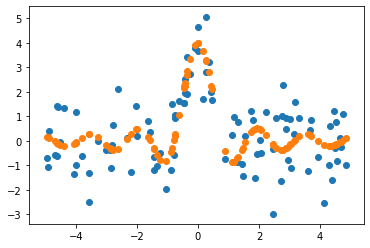

In [5]:
plt.scatter(train_X[:,0], train_Y)
plt.scatter(train_X[:,0], true_func(train_X))
plt.show()

## Setting for learning

In [6]:
### used library
from scipy.spatial import distance_matrix
from scipy.stats import wishart

In [7]:
iteration = 1000
learning_seed = 20190729
M = 10
np.random.seed(learning_seed)

theta1 = 1; theta2 = 2; theta3 = 0.0001
ln_sigma = true_sigma

cronecker_delta_sigma = 0.0001
cronecker_delta = lambda x,y: np.exp(- distance_matrix(x,y)**2/cronecker_delta_sigma)
gauss_kernel = lambda x,y,theta1, theta2, theta3: theta1 * np.exp(- distance_matrix(x,y)**2/theta2) + theta3 * cronecker_delta(x,y)
exp_kernel = lambda x,y,theta1, theta2, theta3: theta1 * np.exp(- distance_matrix(x, y, p=1)/theta2) + theta3 * cronecker_delta(x,y)
used_kernel = gauss_kernel

In [8]:
sub_train_ind = np.argsort(np.random.dirichlet(alpha = np.ones(n), size = 1)).squeeze()[:M]
sub_train_X = train_X[sub_train_ind,:]
sub_train_Y = train_Y[sub_train_ind]

In [13]:
### kernel calculation
train_sub_kernel = used_kernel(train_X, sub_train_X, theta1, theta2, theta3)
sub_sub_kernel = used_kernel(sub_train_X, sub_train_X, theta1, theta2, theta3)
inv_sub_sub_kernel = np.linalg.inv(sub_sub_kernel)
proj_train_sub = train_sub_kernel @ inv_sub_sub_kernel

In [17]:
true_u = true_func(sub_train_X)

In [15]:
### initialization
est_u = np.random.normal(size = M)
est_sigma = wishart.rvs(df = M+2, scale = np.eye(M), size = 1)

In [24]:
obj_func = (np.linalg.slogdet(est_sigma)[1] - np.linalg.slogdet(inv_sub_sub_kernel)[1])/2 - M/2 + 

In [25]:
obj_func

(1.0, 12.674021310700981)

In [21]:
### gradient based calculation
eta0 = 1
for ite in range(iteration):
    du = (inv_sub_sub_kernel + proj_train_sub.T @ proj_train_sub) @ est_u - proj_train_sub.T @ train_Y/ln_sigma
    dsigma = -hat_sigma/2 + inv_sub_sub_kernel/2 + proj_train_sub.T @ proj_train_sub/(2*ln_sigma)
    est_u += -eta0 * du
    est_sigma += -eta0 * dsigma
    break
    pass

NameError: name 'epsilon' is not defined

In [18]:
true_u

array([-0.29589615, -0.17757156,  2.36998793, -0.21701056, -0.18563475,
        2.22302033,  3.65597805,  0.13709608, -0.34575016,  0.02731914])

In [19]:
du

array([    76.00698253,    -59.18450109, -10073.68517859,     70.16417959,
           28.64476509,   9746.27515242,    494.2322649 ,    -40.4673718 ,
           20.35227654,    -64.63921854])

In [20]:
est_u

array([-1.50274774,  1.89437592, -0.08993591,  2.08477826, -0.85014173,
        1.64895204,  2.39740451, -0.89936495,  0.27741541, -0.4933787 ])